In [1]:
import os, zipfile
import numpy as np
import pandas as pd
from tqdm import tqdm
from glob import glob
from pathlib import Path

import ipywidgets
import seaborn as sns
import matplotlib.pyplot as plt

from statistics import mode
from scipy.signal import spectrogram
from scipy.stats import skew, kurtosis

from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from sklearn.ensemble import RandomForestClassifier


In [2]:
def data_ingestion():
    with zipfile.ZipFile(r"D:\Projects\Example\kovai\accelerometer\data\Activity Recognition.zip", 'r') as zip_ref:
        zip_ref.extractall(r'..\data')

    source_data_path = os.path.abspath(r'..\data\Activity Recognition')
    all_data = glob(source_data_path+"/*.csv")

    df = pd.DataFrame()
    for name in all_data:
        df_ = pd.read_csv(name, header=None)
        df_['id'] = int(Path(name).stem)
        df = pd.concat([df, df_.iloc[:,1:]])
    df.columns = ['x', 'y', 'z', 'label', 'id']
    return df


df = data_ingestion()

In [4]:
df.isnull().sum()

x        0
y        0
z        0
label    0
id       0
dtype: int64

In [5]:
activities = {0:"No Activity", 1:"Working at Computer", 2:"Standing Up, Walking and Going up\down stairs", 3:"Standing", 4:"Walking", 5:"Going Up\Down Stairs", 6:"Walking and Talking with Someone", 7:"Talking while Standing"}

In [6]:
df['xf'] = np.real(np.fft.fft(df['x']))
df['yf'] = np.real(np.fft.fft(df['y']))
df['zf'] = np.real(np.fft.fft(df['z']))

In [7]:
per_df = df.groupby(['label']).size() / len(df) * 100
print(per_df)

label
0     0.193005
1    31.587953
2     2.484722
3    11.247986
4    18.530528
5     2.672588
6     2.479117
7    30.804102
dtype: float64


<Axes: title={'center': 'Percentage of Activities recorded'}, xlabel='Activity', ylabel='Percentage'>

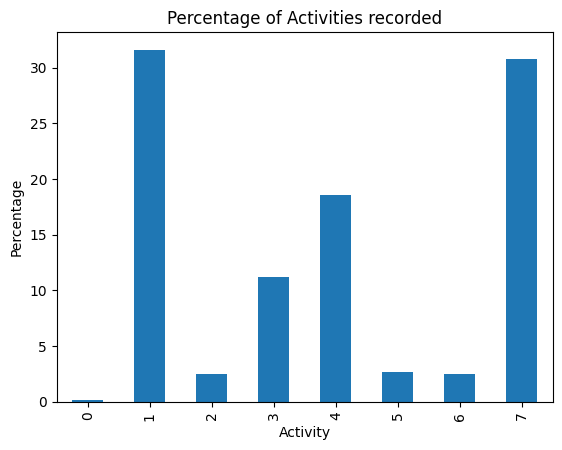

In [8]:
per_df.plot(kind='bar', xlabel='Activity', ylabel='Percentage', title='Percentage of Activities recorded')

label
0      1.191987
1    195.085577
2     15.345513
3     69.466987
4    114.443590
5     16.505769
6     15.310897
7    190.244551
dtype: float64


<Axes: title={'center': 'Time of Activities recorded'}, xlabel='Activity', ylabel='Time in minutes'>

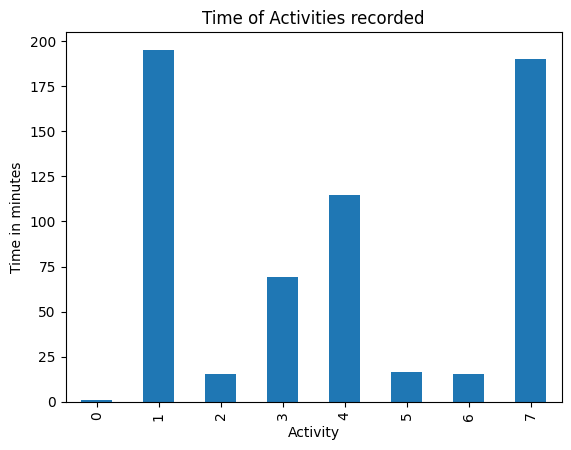

In [9]:
min_df = df.groupby('label').size()/(52 * 60)
print(min_df)


min_df.plot(kind='bar', xlabel='Activity', ylabel='Time in minutes', title='Time of Activities recorded')

In [10]:
def participant_activity_plot_duration(participant_id):
    df_ = df[(df.id==participant_id)]
    min_df = df_.groupby('label').size()/(52 * 60)
    print(min_df)

    min_df.plot(kind='bar', xlabel='Activity', ylabel='Time in minutes', title='Time of Activities recorded')

ipywidgets.interact(participant_activity_plot_duration, participant_id=[i+1 for i in range(15)])

interactive(children=(Dropdown(description='participant_id', options=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1…

<function __main__.participant_activity_plot_duration(participant_id)>

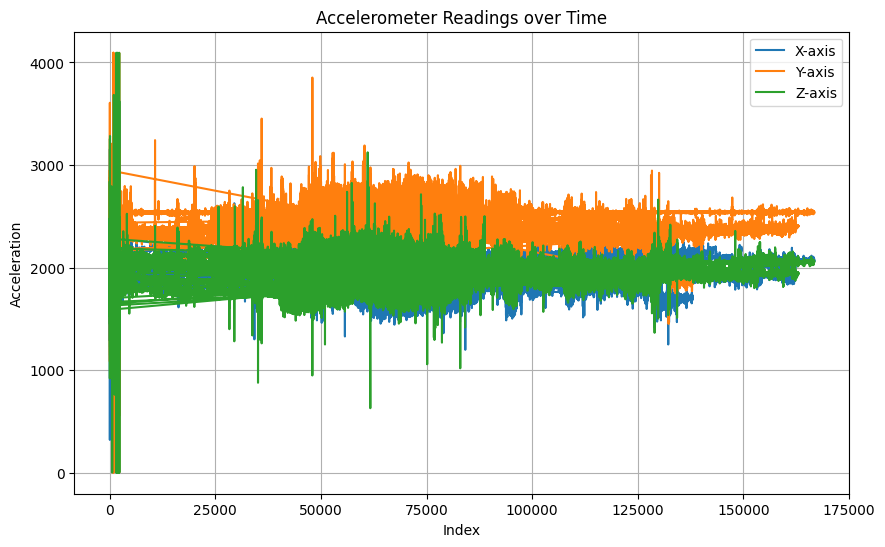

In [11]:
plt.figure(figsize=(10, 6))
plt.plot(df['x'].index, df['x'], label='X-axis')
plt.plot(df['y'].index, df['y'], label='Y-axis')
plt.plot(df['z'].index, df['z'], label='Z-axis')
plt.title('Accelerometer Readings over Time')
plt.xlabel('Index')
plt.ylabel('Acceleration')
plt.legend()
plt.grid(True)
plt.show()


In [12]:
def plot_participant(participant_id, activity):
    subject = df[(df.id==participant_id) & (df.label==activity)].iloc[:,:3].values
    
    plt.figure()
    for t in range(subject.shape[1]):
        plt.subplot(subject.shape[1], 1, t+1)
        plt.plot(subject[:,t])
    plt.subplots_adjust(wspace=0.1, hspace=0.5)
    plt.show()

    
ipywidgets.interact(plot_participant, participant_id=[i+1 for i in range(15)], activity=range(8))

interactive(children=(Dropdown(description='participant_id', options=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1…

<function __main__.plot_participant(participant_id, activity)>

d:\Projects\Example\venv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


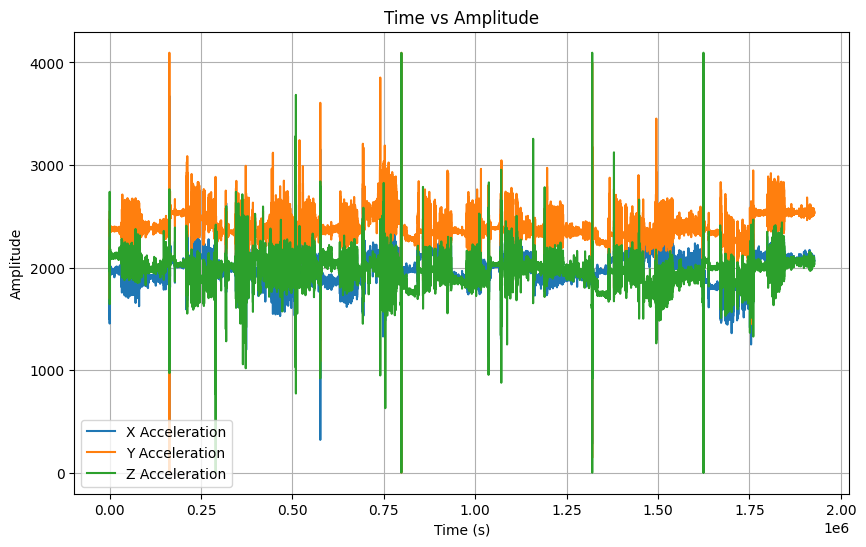

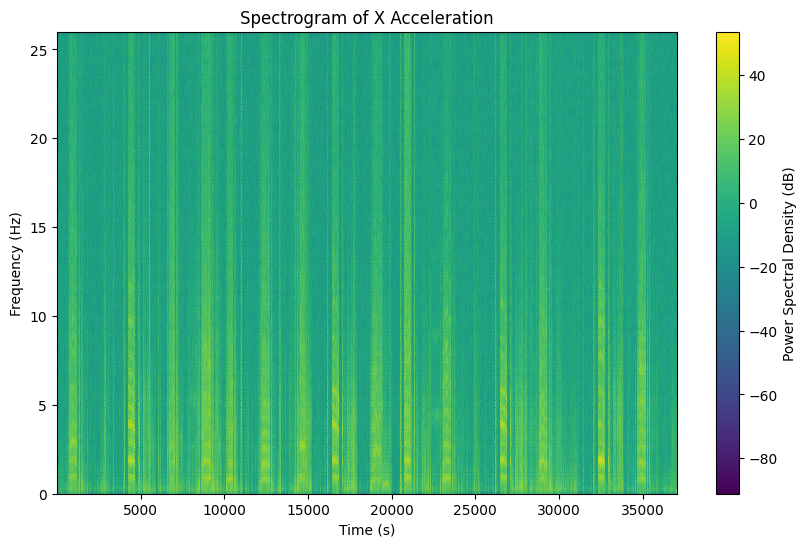

In [13]:
time = np.arange(0, len(df), 1)
x = df['x']
y = df['y']
z = df['z']

# Time vs Amplitude plot
plt.figure(figsize=(10, 6))
plt.plot(time, df['x'], label='X Acceleration')
plt.plot(time, df['y'], label='Y Acceleration')
plt.plot(time, df['z'], label='Z Acceleration')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Time vs Amplitude')
plt.legend()
plt.grid(True)
plt.show()

# Compute FFT for each axis
fft_x = np.fft.fft(x)
fft_y = np.fft.fft(y)
fft_z = np.fft.fft(z)

# Frequency axis
frequency = np.fft.fftfreq(len(time), d=1)

# Frequency vs Time plot
fs = 52
plt.figure(figsize=(10, 6))
f, t, Sxx = spectrogram(df['x'], fs=fs, noverlap=int(fs * 0.5))
plt.pcolormesh(t, f, 10 * np.log10(Sxx), shading='gouraud')
plt.title('Spectrogram of X Acceleration')
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (s)')
plt.colorbar(label='Power Spectral Density (dB)')
plt.show()

In [14]:
def segment_signal(signal, window_length_sec, overlap_ratio=0.5, sampling_rate=52):
    window_length_samples = int(window_length_sec * sampling_rate)
    overlap_length = int(window_length_samples * overlap_ratio)
    stride = window_length_samples - overlap_length
    segments = []
    for i in range(0, len(signal) - window_length_samples + 1, stride):
        segment = signal[i:i + window_length_samples]
        segments.append(segment)
    return segments


segments = []
for k, df_ in df.groupby(['id', 'label']):
    sensor_data = df_
    window_length_sec = 1
    sampling_rate = 52
    segments.extend(segment_signal(sensor_data, window_length_sec))

# print("Number of Segments:", len(segments))
# print("First Few Segments:")
# for i in range(min(2, len(segments))):
#     print("Segment", i + 1, ":", segments[i])


In [15]:
def extract_features(segment_data):
    features = [np.mean(segment_data[['x','y','z']].apply(lambda df_: np.sqrt(df_.x**2 + df_.y**2 + df_.z**2), axis=1))]
    features.append(np.mean(np.correlate(segment_data['x'], segment_data['y'], mode='full')))
    features.append(np.mean(np.correlate(segment_data['x'], segment_data['z'], mode='full')))
    features.append(np.mean(np.correlate(segment_data['z'], segment_data['y'], mode='full')))
    
    label = mode(segment_data['label'])

    for col in ['x', 'y', 'z']:
        segment = segment_data[col]
        features.append(np.mean(segment))
        features.append(np.var(segment))
        features.append(np.std(segment))
        features.append(skew(segment))
        features.append(kurtosis(segment))
        features.append(np.percentile(segment, 25))
        features.append(np.percentile(segment, 50))
        features.append(np.percentile(segment, 75))
        features.append(np.min(segment))
        features.append(np.max(segment))

    segment = segment_data[['xf', 'yf', 'zf']]
    _, _, Sxx = spectrogram(segment, fs=sampling_rate, nperseg=3)
    mean_power = np.mean(Sxx)
    max_power = np.max(Sxx)
    min_power = np.min(Sxx)

    features.append(mean_power)
    features.append(max_power)
    features.append(min_power)
        
    return features, label, segment_data.index


train_data = [extract_features(segment) for segment in tqdm(segments, total=len(segments))]

X = pd.DataFrame([i for i, j, idx in train_data])
y = pd.Series([j for i, j, idx in train_data])
indices = pd.Series([idx for i, j, idx in train_data])

100%|██████████| 73953/73953 [05:41<00:00, 216.48it/s]


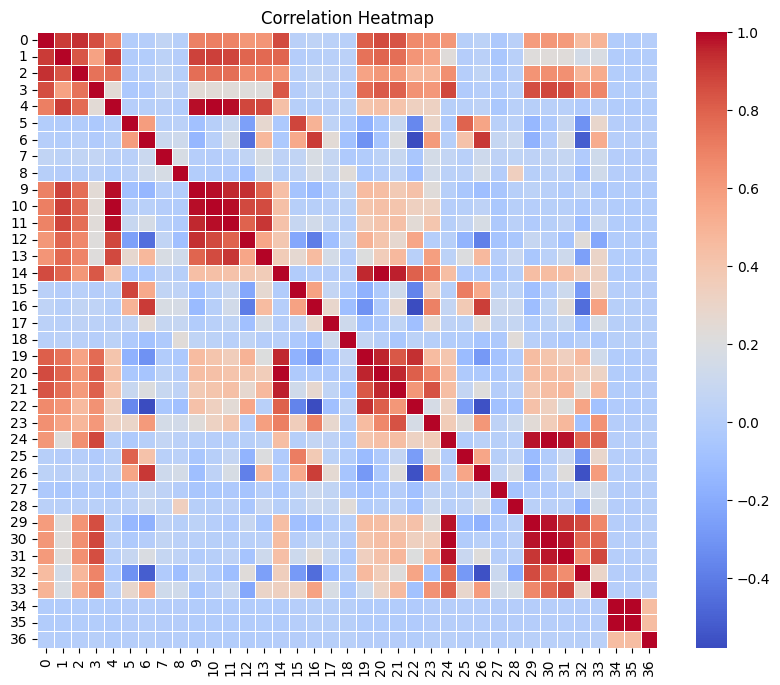

In [16]:
plt.figure(figsize=(10, 8))
sns.heatmap(X.corr(), annot=False, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap')
plt.show()

[0.9058887161111486, 0.9104184977351092, 0.9066324116016496, 0.9074374577417174, 0.9076402974983097]
Average accuracy: 0.9076034761375869
              precision    recall  f1-score   support

           0       0.78      0.56      0.65        25
           1       0.97      0.98      0.97      4752
           2       0.86      0.52      0.65       367
           3       0.82      0.74      0.78      1649
           4       0.87      0.96      0.91      2696
           5       0.81      0.57      0.67       404
           6       0.81      0.44      0.57       342
           7       0.91      0.96      0.94      4555

    accuracy                           0.91     14790
   macro avg       0.85      0.72      0.77     14790
weighted avg       0.90      0.91      0.90     14790



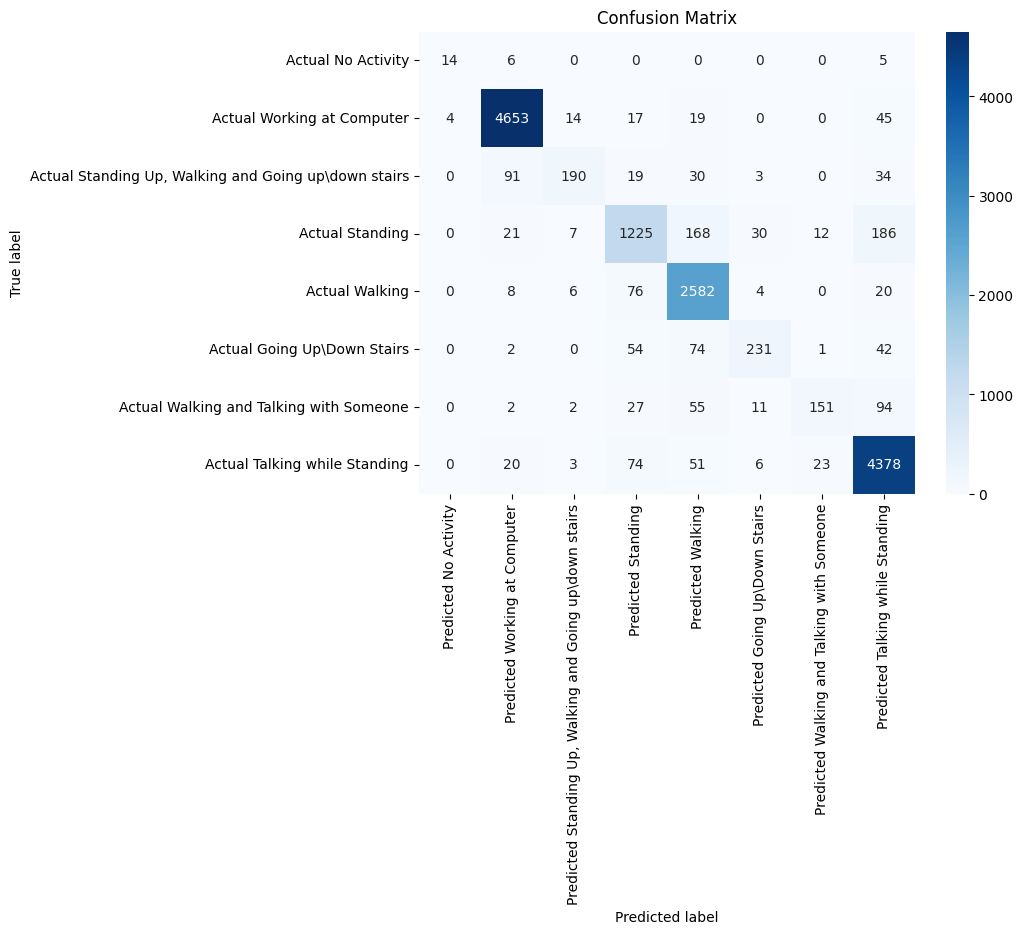

In [17]:
def model_creation(X, y, num_folds=5):
    accuracy_scores = []
    kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)
    for train_index, test_index in kf.split(X):
        best_accuracy = 0
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        indices_train, indices_test = indices[train_index], indices[test_index]
        
        model = RandomForestClassifier(n_jobs=-1)
        model.fit(X_train, y_train)
        
        y_pred = model.predict(X_test)
        
        accuracy = accuracy_score(y_test, y_pred)
        accuracy_scores.append(accuracy)

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_model = model

    average_accuracy = np.mean(accuracy_scores)
    print(accuracy_scores)
    print("Average accuracy:", average_accuracy)

    return best_model, X_train, X_test, y_train, y_test, indices_train, indices_test


def model_classification_report(y_test, y_pred):
    # Calculate & Print Classification Report
    print(classification_report(y_test, y_pred))


def model_confusion_matrix(y_test, y_pred):
    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=[f'Predicted {activities[i]}' for i in set(y)], 
                yticklabels=[f'Actual {activities[i]}' for i in set(y)])
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title('Confusion Matrix')
    plt.show()



model, X_train, X_test, y_train, y_test, indices_train, indices_test = model_creation(X, y)
model_classification_report(y_test, model.predict(X_test))
model_confusion_matrix(y_test, model.predict(X_test))

In [38]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize Random Forest classifier
rf_classifier = RandomForestClassifier(n_jobs=-1)

# Initialize GridSearchCV with Random Forest classifier and parameter grid
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5, scoring='accuracy')

# Perform grid search on training data
grid_search.fit(X_train, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best parameters:", best_params)
print("Best score:", best_score)

# Make predictions on the testing data using the best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Best parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best score: 0.9040599892337624
Accuracy: 0.9067676289635589


In [42]:
print("Predicted Label: ", y_test.iloc[1000])
df.iloc[indices_test.iloc[1000]]

Predicted Label:  7


,x,y,z,label,id,xf,yf,zf
127762,1906,2388,2004,7,1,-35151.250553,-22307.651181,32278.971364
127763,1899,2387,1995,7,1,-8845.517773,114216.482562,-42071.709552
127764,1901,2380,1998,7,1,69843.228887,-93377.663517,78393.268866
127765,1899,2381,2002,7,1,9747.780225,75261.369817,-75823.425221
127766,1903,2385,1993,7,1,-77162.126595,85294.074301,40841.056994
127767,1899,2383,1995,7,1,14870.944259,24846.554344,-39611.596880
127768,1899,2386,1997,7,1,-43048.225565,118736.993712,-127163.787653
127769,1903,2382,1999,7,1,18866.516934,-4864.413934,-29556.084755
127770,1902,2382,1998,7,1,25795.773339,-157496.967693,49950.526606
127771,1905,2383,2002,7,1,58047.635449,45928.220151,17886.800089


In [43]:
df_without_none = df[~(df['label'].isin([0]))]
df_without_none.head()

,x,y,z,label,id,xf,yf,zf
0,1502,2215,2153,1,1,3.829999e+09,4.590874e+09,3.797134e+09
1,1667,2072,2047,1,1,-1.319028e+07,2.630536e+07,1.717360e+07
2,1611,1957,1906,1,1,1.305241e+07,3.863771e+07,2.834394e+07
3,1601,1939,1831,1,1,-1.675205e+07,2.076640e+07,3.147413e+07
4,1643,1965,1879,1,1,2.354784e+07,-1.746952e+07,2.204647e+06


In [44]:
segments_without_none = []
for k, df_ in df_without_none.groupby(['id', 'label']):
    sensor_data = df_
    window_length_sec = 1
    sampling_rate = 52
    segments_without_none.extend(segment_signal(sensor_data, window_length_sec))


train_data_without_none = [extract_features(segment) for segment in tqdm(segments_without_none, total=len(segments_without_none))]

X1 = pd.DataFrame([i for i, j, idx in train_data_without_none])
y1 = pd.Series([j for i, j, idx in train_data_without_none])
indices1 = pd.Series([idx for i, j, idx in train_data_without_none])

100%|██████████| 73817/73817 [18:38<00:00, 65.99it/s]   


[0.9043619615280412, 0.9119479815768085, 0.9088938562622774, 0.9064553275079591, 0.9061843798685904]
Average accuracy: 0.9075687013487354
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.99      1.00      1.00      4746
           2       0.98      0.90      0.94       343
           3       0.96      0.95      0.95      1660
           4       0.97      0.99      0.98      2690
           5       0.98      0.91      0.94       406
           6       0.98      0.85      0.91       363
           7       0.98      0.99      0.98      4555

    accuracy                           0.98     14763
   macro avg       0.85      0.82      0.84     14763
weighted avg       0.98      0.98      0.98     14763



d:\Projects\Example\venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Projects\Example\venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Projects\Example\venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


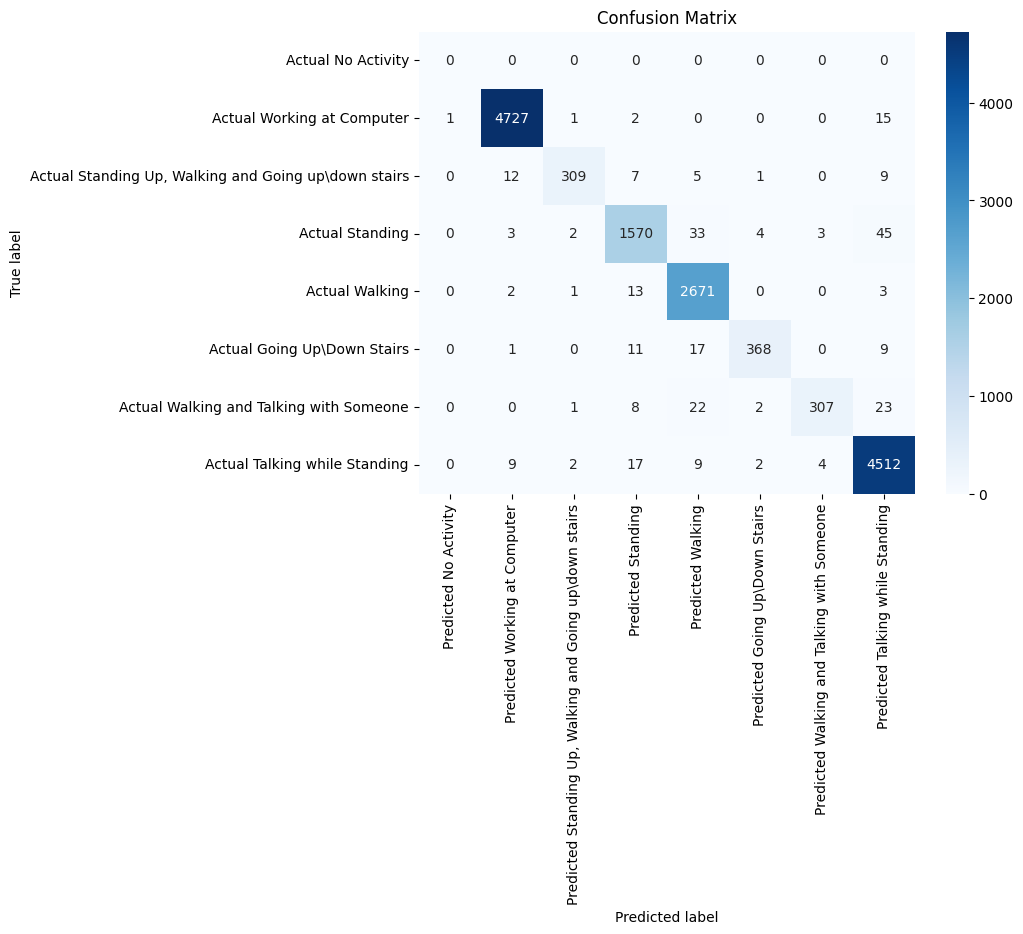

In [46]:
model1, X_train1, X_test1, y_train1, y_test1, indices_train1, indices_test1 = model_creation(X1, y1)
model_classification_report(y_test1, model.predict(X_test1))
model_confusion_matrix(y_test1, model.predict(X_test1))

In [49]:
print("Predicted Label: ", y_test1.iloc[500])
df.iloc[indices_test1.iloc[500]]

Predicted Label:  4


,x,y,z,label,id,xf,yf,zf
55128,1926,2367,2008,4,1,-14350.890265,159002.024256,49158.076731
55129,1935,2414,2032,4,1,-20072.582223,62272.908474,-42851.396349
55130,1944,2466,2018,4,1,-4278.806946,-12236.033507,9288.902875
55131,1935,2509,2026,4,1,3959.223857,-27031.534839,78684.647271
55132,1906,2542,2023,4,1,-65596.105068,108178.884173,-40561.096339
55133,1905,2522,1978,4,1,26507.340283,-45535.100714,82086.597998
55134,1914,2561,2159,4,1,30633.565787,24412.192640,-52064.366102
55135,1939,2588,2183,4,1,7588.540814,-14065.332833,-65297.690984
55136,1923,2565,2145,4,1,-11659.835902,-104894.368141,4185.743879
55137,1816,2455,2165,4,1,-31380.051323,116099.443677,20737.138313


In [51]:
df_without_stairs = df[~(df['label'].isin([0,2,6]))]

segments_without_stairs = []
for k, df_ in df_without_stairs.groupby(['id', 'label']):
    sensor_data = df_
    window_length_sec = 1
    sampling_rate = 52
    segments_without_stairs.extend(segment_signal(sensor_data, window_length_sec))


train_data_without_stairs = [extract_features(segment) for segment in tqdm(segments_without_stairs, total=len(segments_without_stairs))]

100%|██████████| 70181/70181 [05:14<00:00, 223.29it/s]


ValueError: too many values to unpack (expected 2)

In [52]:
X2 = pd.DataFrame([i for i, j, idx in train_data_without_stairs])
y2 = pd.Series([j for i, j, idx in train_data_without_stairs])
indices2 = pd.Series([idx for i, j, idx in train_data_without_stairs])


[0.9333190852746314, 0.932815616984896, 0.9342405243659162, 0.9338842975206612, 0.9315332003419777]
Average accuracy: 0.9331585448976165
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      1.00      1.00      4657
           2       0.00      0.00      0.00         0
           3       0.98      0.95      0.96      1658
           4       0.98      0.99      0.99      2771
           5       0.98      0.92      0.95       387
           6       0.00      0.00      0.00         0
           7       0.99      0.99      0.99      4563

    accuracy                           0.99     14036
   macro avg       0.61      0.61      0.61     14036
weighted avg       0.99      0.99      0.99     14036



d:\Projects\Example\venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Projects\Example\venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Projects\Example\venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


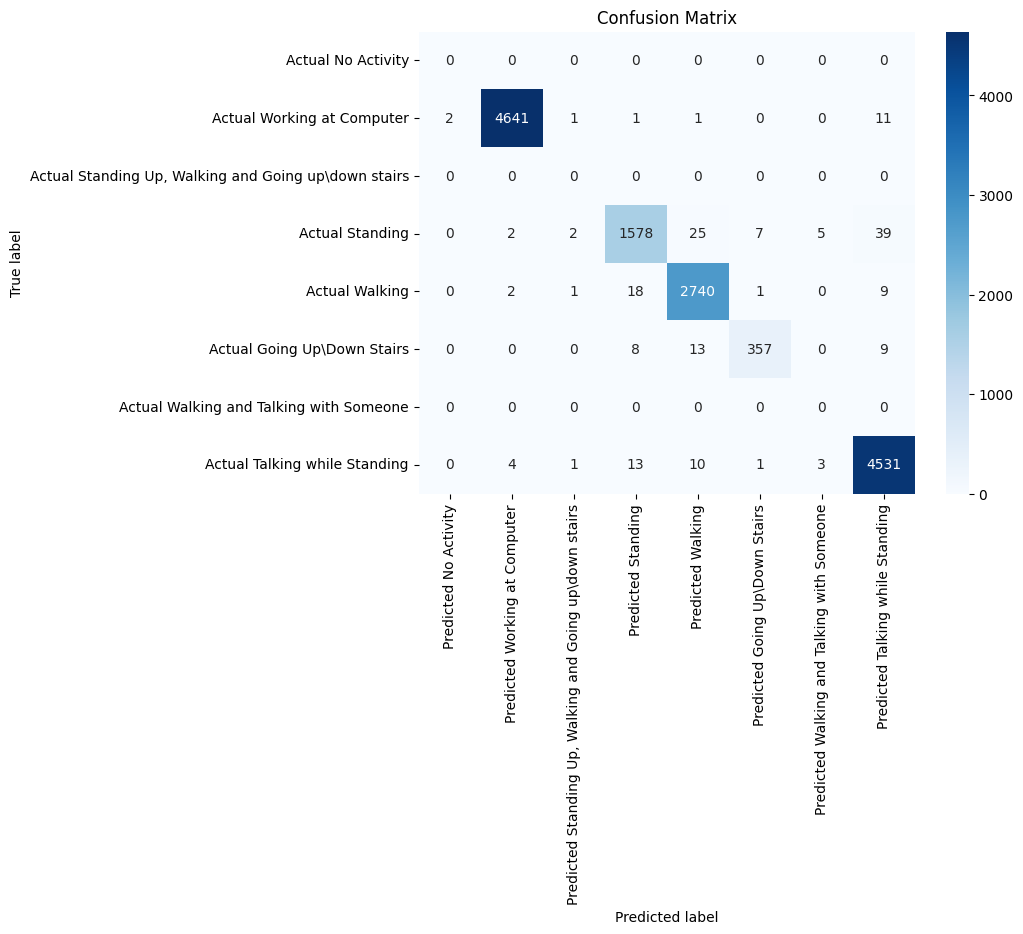

In [53]:
model2, X_train2, X_test2, y_train2, y_test2, indices_train2, indices_test2 = model_creation(X2, y2)
model_classification_report(y_test2, model.predict(X_test2))
model_confusion_matrix(y_test2, model.predict(X_test2))

In [54]:
print("Predicted Label: ", y_test2.iloc[500])
df.iloc[indices_test2.iloc[500]]

Predicted Label:  4


,x,y,z,label,id,xf,yf,zf
54426,1957,2244,2018,4,1,-28971.143648,60125.348851,-64537.552831
54427,1946,2243,2026,4,1,-38447.461546,16451.747838,-58769.216634
54428,1915,2251,2046,4,1,-20419.638145,38796.844251,10050.247109
54429,1900,2256,2031,4,1,66018.102138,-135700.938054,-22819.684729
54430,1882,2284,2037,4,1,12149.592598,26693.997301,30083.934891
54431,1872,2319,2038,4,1,-237.276186,150670.869667,-12596.495712
54432,1870,2364,2038,4,1,34444.471506,-135532.734882,22802.363821
54433,1858,2430,2016,4,1,-2808.884967,92508.531469,93025.185372
54434,1843,2489,1998,4,1,-20153.776999,89717.638737,-8028.518484
54435,1794,2530,1973,4,1,-33468.972201,-127931.271621,-52942.278229


           x     y     z  label  id            xf            yf            zf
84      1670  2147  2079      1   1  1.015781e+04  1.509990e+06 -1.610579e+06
88      1726  2203  2005      1   1  1.127980e+06  1.264366e+05 -3.183430e+06
89      1778  2143  1946      1   1 -3.944368e+05 -3.356486e+06 -7.472268e+04
90      1718  2102  2012      1   1 -2.121419e+06 -1.576565e+06  7.357328e+05
93      1664  2241  2064      1   1  9.974608e+05  1.125004e+06  2.328428e+06
...      ...   ...   ...    ...  ..           ...           ...           ...
166720  2069  2533  2061      7   9  2.389909e+06 -2.633939e+06 -1.012934e+06
166722  2078  2529  2064      7   9 -1.210291e+06 -3.676260e+06 -1.686623e+05
166723  2075  2534  2061      7   9 -1.587717e+06  2.891647e+06 -3.428117e+06
166725  2071  2546  2066      7   9 -3.837679e+06  1.919484e+06 -6.904350e+06
166731  2070  2540  2065      7   9 -5.532184e+06  9.777583e+05 -5.927402e+06

[1801782 rows x 8 columns]


100%|██████████| 69189/69189 [05:06<00:00, 225.39it/s]


[0.9329382858794624, 0.9328660211013152, 0.9325769619887267, 0.9341667871079635, 0.9310544193105442]
Average accuracy: 0.9327204950776025
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.99      0.99      0.99      4616
           2       0.00      0.00      0.00         0
           3       0.94      0.84      0.89      1661
           4       0.93      0.98      0.96      2641
           5       0.95      0.79      0.86       397
           6       0.00      0.00      0.00         0
           7       0.96      0.99      0.98      4522

    accuracy                           0.96     13837
   macro avg       0.60      0.57      0.58     13837
weighted avg       0.97      0.96      0.96     13837



d:\Projects\Example\venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Projects\Example\venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Projects\Example\venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


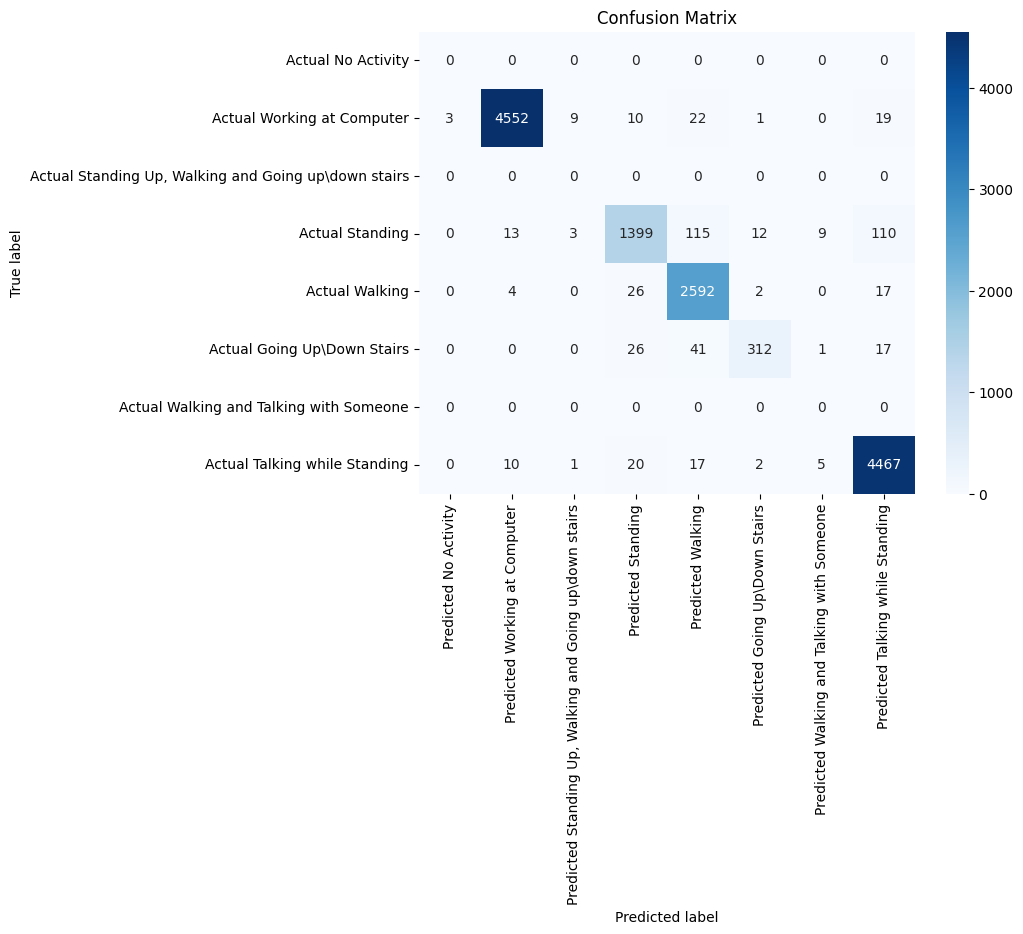

In [55]:
def remove_outliers_zscore(df, threshold=3):
    z_scores = df.apply(lambda x: np.abs((x - x.mean()) / x.std()))
    return df[(z_scores < threshold).all(axis=1)]

df_without_stairs_outliers = remove_outliers_zscore(df[~(df['label'].isin([0,2,6]))])
print(df_without_stairs_outliers.head())

segments_without_stairs_outliers = []
for k, df_ in df_without_stairs_outliers.groupby(['id', 'label']):
    sensor_data = df_
    window_length_sec = 1
    sampling_rate = 52
    segments_without_stairs_outliers.extend(segment_signal(sensor_data, window_length_sec))


train_data_without_stairs_outliers = [extract_features(segment) for segment in tqdm(segments_without_stairs_outliers, total=len(segments_without_stairs_outliers))]

X3 = pd.DataFrame([i for i, j, idx in train_data_without_stairs_outliers])
y3 = pd.Series([j for i, j, idx in train_data_without_stairs_outliers])
indices3 = pd.Series([idx for i, j, idx in train_data_without_stairs_outliers])

model3, X_train3, X_test3, y_train3, y_test3, indices_train3, indices_test3 = model_creation(X3, y3)
model_classification_report(y_test3, model.predict(X_test3))
model_confusion_matrix(y_test3, model.predict(X_test3))

In [57]:
import joblib


def save_model(model, output_path):
    os.makedirs(output_path, exist_ok=True)
    joblib.dump(model, os.path.join(output_path, "model.pkl"))


def load_model(model_path):
    try:
        joblib.load(os.path.join(model_path, "model.pkl"))
    except:
        print("Unable to load model")

In [60]:
save_model(model, r"..\artifacts\model_all_data")
save_model(model1, r"..\artifacts\model_without_none")
save_model(model2, r"..\artifacts\model_without_026")
save_model(model3, r"..\artifacts\model_handled_outliers_removed_026")

In [85]:
# n_components = 20
# pca = PCA(n_components=n_components)

# pca.fit(X3)
# X3_pca = pca.transform(X3)

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()


# model_creation(pd.DataFrame(X3_pca), y3)
# model = model_creation(pd.DataFrame(scaler.fit_transform(X3), columns=X3.columns), y3)


y3.value_counts()


# # Plot confusion matrix
# y_pred_1 = model.predict(pd.DataFrame(scaler.fit_transform(X_test), columns=X_test.columns))
# cm = confusion_matrix(y_test, y_pred_1, labels=[0, 1,3,4,5,7])
# plt.figure(figsize=(8, 6))
# sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=['Predicted 0', 'Predicted 1'], 
#             yticklabels=['Actual 0', 'Actual 1'])
# plt.xlabel('Predicted label')
# plt.ylabel('True label')
# plt.title('Confusion Matrix')
# plt.show()
# cm

1    23084
7    22538
4    13394
3     8241
5     1932
Name: count, dtype: int64